In [48]:
pip install pandas numpy scipy matplotlib seaborn pyroomacoustics ipympl statsmodels

In [6]:
try:
  import google.colab
  !git clone https://github.com/GonzaLinares/PASA_Proyecto2
  !mv ./PASA_Proyecto2/helperRLS.py ./helperRLS.py
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.signal as sp
import scipy.linalg as linalg
import scipy.io as io
import helperRLS as hp
import importlib
import pyroomacoustics as pra
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from IPython.display import Audio, update_display
from ipywidgets import IntProgress
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
%load_ext autoreload
%autoreload 2

<img src="https://imgur.com/AvqszhU.png" width=800>

<img src="https://i.imgur.com/HHntd5f.png">

# Importo respuestas impulsivas de BOSE QC20

Estaria bueno explicar un poco la composicion del database este. Dejo el link https://pub.dega-akustik.de/ICA2019/data/articles/000741.pdf

Tambien estaria bueno describir lo que se usa: el camino P y S, describir el orden y puede ser algun espectro para mostrar la respuesta en freq.

In [24]:
if IN_COLAB:
  elecBackITA = io.loadmat("./PASA_Proyecto2/PANDAR_database_1.0/BoseQC20/electronic_backend/PANDAR_TF_201_backend_dSPACE.ita")
  acousticPathsITA = io.loadmat("./PASA_Proyecto2/PANDAR_database_1.0/BoseQC20/acoustic_booth/persons/PANDAR_TF_001_person_BoseQC20.ita")
else:
  elecBackITA = io.loadmat("./PANDAR_database_1.0/BoseQC20/electronic_backend/PANDAR_TF_201_backend_dSPACE.ita")
  acousticPathsITA = io.loadmat("./PANDAR_database_1.0/BoseQC20/acoustic_booth/persons/PANDAR_TF_001_person_BoseQC20.ita")


fs = 48000

In [8]:
elecBack = elecBackITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][14].T        # Direct, Lowcut, AAF, PreAmp En este orden estan las resp impulsivas

display(elecBackITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][16])
display(elecBack.shape)

array([[array(['Direct'], dtype='<U6')],
       [array(['LowCut'], dtype='<U6')],
       [array(['AAF'], dtype='<U3')],
       [array(['Preamp'], dtype='<U6')]], dtype=object)

(4, 8192)

In [29]:
acousticPaths = np.array(acousticPathsITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][14]).T   # SecL, SecR, FeedBL, FeedBR, primL, PrimR

acousticPathsITA['ITA_TOOLBOX_AUDIO_OBJECT'][0][0][16]

array([[array(['SecondaryL'], dtype='<U10')],
       [array(['SecondaryR'], dtype='<U10')],
       [array(['FeedbackL'], dtype='<U9')],
       [array(['FeedbackR'], dtype='<U9')],
       [array(['PrimaryL'], dtype='<U8')],
       [array(['PrimaryR'], dtype='<U8')]], dtype=object)

<img src="https://i.imgur.com/Lpvgzg9.png">

In [28]:
plt.figure(figsize=(10, 10))

freqPp, Pp = sp.freqz(acousticPaths[4], [1], fs=48000, worN=10000)
freqPs, Ps = sp.freqz(acousticPaths[0], [1], fs=48000, worN=10000)
plt.subplot(211)
plt.semilogx(freqPp, 20*np.log10(np.abs(Pp)))
plt.subplot(212)
plt.semilogx(freqPs, 20*np.log10(np.abs(Ps)))
plt.legend()

1326.0


ValueError: could not broadcast input array from shape (1326,) into shape (8192,)

<Figure size 1000x1000 with 0 Axes>

# Genero el aparato experimental simulado

Esto hay que explicarlo. En la generacion se uso Pyroom con el metodo de imagen de fuente y ademas raytracing. Se simularon por lo menos 3 ordenes de reflejos, y el material usado fue el rough concrete, que esta en Pyroom.
Hay que describir el cuartucho este, y presentar las respuestas simuladas y el orden.

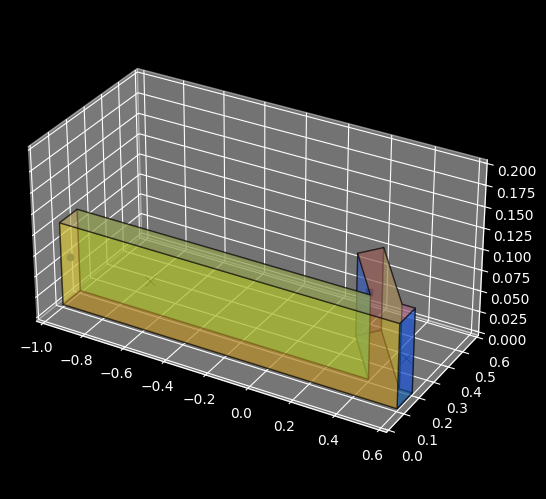

In [11]:
room = hp.createRoom(print=True)

<img src="https://imgur.com/X6lTncP.png">

(<Figure size 640x480 with 4 Axes>,
 array([[<Axes: title={'center': 'Source 0'}>,
         <Axes: title={'center': 'Source 1'}>],
        [<Axes: xlabel='Time (ms)'>, <Axes: xlabel='Time (ms)'>]],
       dtype=object))

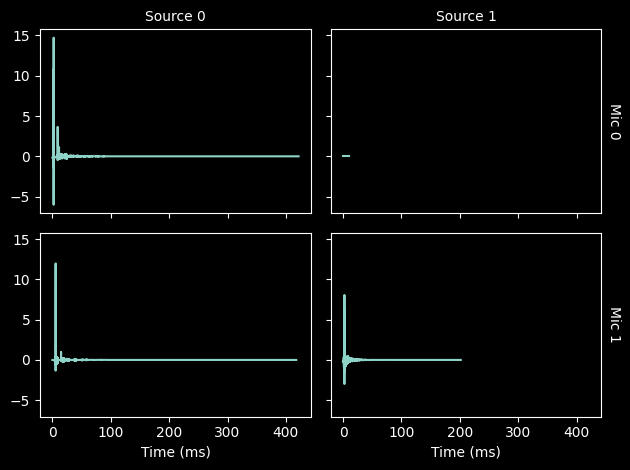

In [12]:
room.plot_rir()

In [13]:
Proom = hp.getProomImpulse()[0][0]

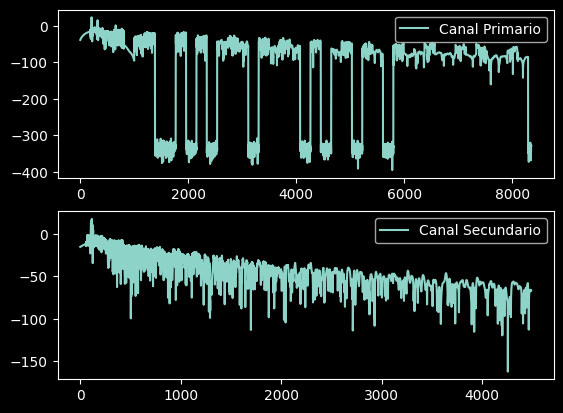

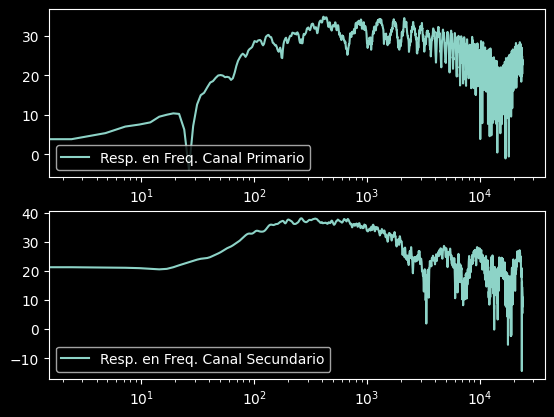

In [14]:
room.rir # dim = (mic_n, source_n) -> P = []
Sroom = room.rir[1][1]

rt60_time_P = pra.measure_rt60(Proom)

Proom = Proom[:int(rt60_time_P)]

rt60_time_S = pra.measure_rt60(Sroom)

Sroom = Sroom[:int(rt60_time_S)]

plt.figure()
plt.subplot(211)
plt.plot(20*np.log10(np.abs(Proom)), label='Canal Primario')
plt.legend()
plt.subplot(212)
plt.plot(20*np.log10(np.abs(Sroom)), label='Canal Secundario')
plt.legend()

plt.figure()

freqPp, Pp = sp.freqz(Proom, [1], fs=48000, worN=10000)
freqPs, Ps = sp.freqz(Sroom, [1], fs=48000, worN=10000)
plt.subplot(211)
plt.semilogx(freqPp, 20*np.log10(np.abs(Pp)), label='Resp. en Freq. Canal Primario')
plt.legend()

plt.subplot(212)
plt.semilogx(freqPs, 20*np.log10(np.abs(Ps)), label='Resp. en Freq. Canal Secundario')
plt.legend()

# Importo Algunas muestras de audio para utilizar como señal para querer escuchar

In [15]:
if IN_COLAB:
  _, Voice = io.wavfile.read("./PASA_Proyecto2/Voice.wav")
  _, Song = io.wavfile.read("./PASA_Proyecto2/Song.wav")
else:
  _, Voice = io.wavfile.read("Voice.wav")
  _, Song = io.wavfile.read("Song.wav")

Song = Song.T


/tmp/ipykernel_39147/3154747844.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, Voice = io.wavfile.read("Voice.wav")
/tmp/ipykernel_39147/3154747844.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, Song = io.wavfile.read("Song.wav")


# Importo algunos sonidos para utilizar como interferencias

In [16]:
if IN_COLAB:
  _, Street = io.wavfile.read("./PASA_Proyecto2/ruidoCalle.wav")
else:
  _, Street = io.wavfile.read("ruidoCalle.wav")
Street = Street.T

/tmp/ipykernel_39147/2886747250.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, Street = io.wavfile.read("ruidoCalle.wav")


# FX-RLS

Lambda se selecciono:
$$
\begin{gather*}
\tau = T_{\text{correlación}} * f_s\\
\lambda = e^{-1/tau} = 0.999306\\
f_s = 48\text{kHz}\\
T_{\text{correlación}} = 30\text{ms}
\end{gather*}
$$

Delta se selecciono:
$$
\begin{gather*}
\delta = \sigma_{x_f}^2 * (1-\lambda)^\alpha\\
\alpha = 1\\
\text{SNR mayor a 30dB en aplicaciones de audio}
\end{gather*}
$$

La cantidad de Snapshots se eligio empiricamente.




In [61]:
x = lambda n: np.random.normal(0, 1, size=n if isinstance(n, (int, float)) else len(n) )

sound = lambda n: 0

w_order = 10
wi = np.zeros(w_order)
mu = 1

# FIR orden 50 con f de corte en 15KHz
P = ([0.25710141,  0.56759341,  0.36275683, -0.14074494, -0.16174654,   \
        0.12823306,  0.05811698, -0.11620306,  0.01515356,  0.08046367, \
       -0.05774555, -0.02982777,  0.06513562, -0.0166772 , -0.04321455, \
        0.04235021,  0.00806632, -0.0412385 ,  0.02130754,  0.02045124, \
       -0.03241952,  0.00518836,  0.02412965, -0.02152481, -0.00541805, \
        0.02237718, -0.01142921, -0.01095489,  0.01772157, -0.00348454, \
       -0.01262484,  0.0122324 ,  0.00174199, -0.01165468,  0.00714404, \
        0.0045253 , -0.00938547,  0.00326163,  0.00533944, -0.00672168, \
        0.00069973,  0.00497453, -0.00439681, -0.00061501,  0.00400033, \
       -0.00263338, -0.00110586,  0.00297181, -0.00153013, -0.00108514], [1] )


S = ([ 0.25710141,  0.56759341,  0.36275683, -0.14074494, -0.16174654,  \
        0.12823306,  0.05811698, -0.11620306,  0.01515356,  0.08046367, \
       -0.05774555, -0.02982777,  0.06513562, -0.0166772 , -0.04321455, \
        0.04235021,  0.00806632, -0.0412385 ,  0.02130754,  0.02045124, \
       -0.03241952,  0.00518836,  0.02412965, -0.02152481, -0.00541805, \
        0.02237718, -0.01142921, -0.01095489,  0.01772157, -0.00348454, \
       -0.01262484,  0.0122324 ,  0.00174199, -0.01165468,  0.00714404, \
        0.0045253 , -0.00938547,  0.00326163,  0.00533944, -0.00672168, \
        0.00069973,  0.00497453, -0.00439681, -0.00061501,  0.00400033, \
       -0.00263338, -0.00110586,  0.00297181, -0.00153013, -0.00108514], [1] )

S_hat = S

N = 100000
x_test = x(N)
xf = sp.lfilter(S[0], S[1], x(N))
N = len(xf)
R = sp.correlate(xf, xf)/N
R = R[N-w_order: N][::-1]
matR = linalg.toeplitz(R)
lambdas, _= linalg.eig(matR)

sigmaS = np.sum(np.array(S[0])**2)
k = np.arange(len(S[0]))
tauS = np.sum(k*np.array(S[0])**2)
deltaEq = tauS/sigmaS

lamdaRLS = np.exp(-1/fs*30e-3) # 0.999306
deltaRLS = np.var(xf) * (1-lamdaRLS)
print("Delta RLS: ", deltaRLS)
mu = 1/(np.var(xf)*(w_order + 2*deltaEq))


results_lms = hp.fxnlms_sim(wi, mu, P, S, S_hat, x, sound, w_order, N = fs*8)

results_rls = hp.fxrls_sim(lamdaRLS, deltaRLS, P, S, S_hat, x, sound, w_order, w_order + 50, N = fs*8)

Delta RLS:  3.890151379216634e-07


IntProgress(value=0, max=384000)

2.447902357746735e-10

IntProgress(value=0, max=384000)

'Señal error LMS:'

'Señal error RLS:'

'Señal interferencia:'

'Señal interferencia + sonido:'

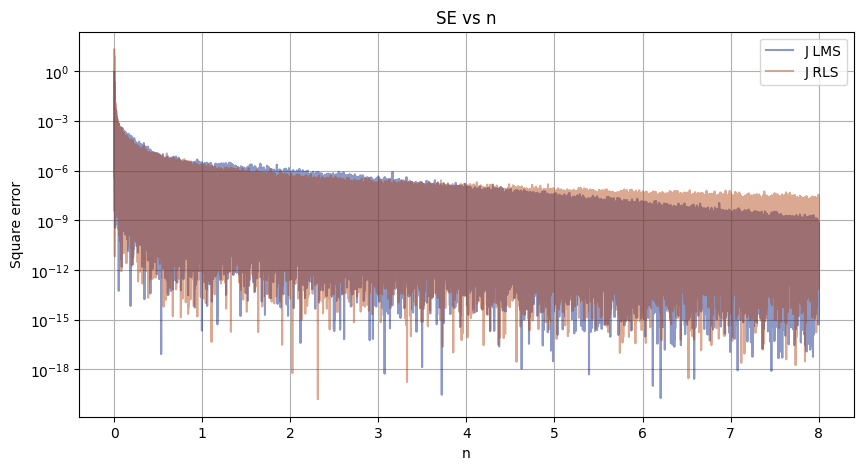

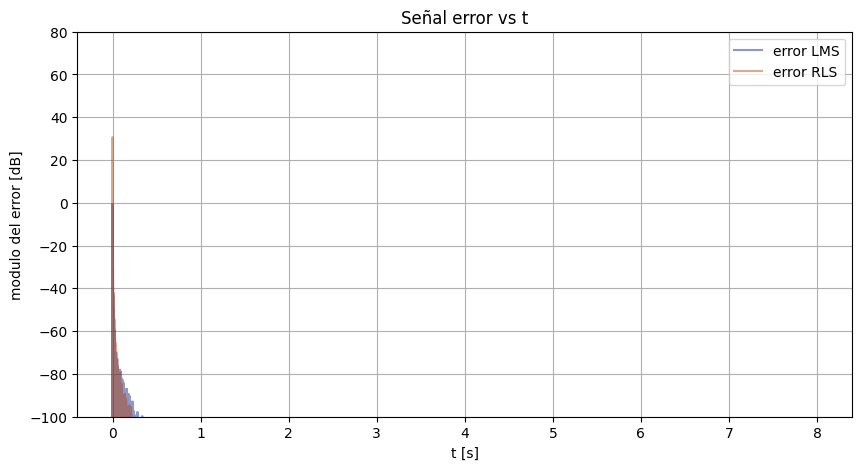

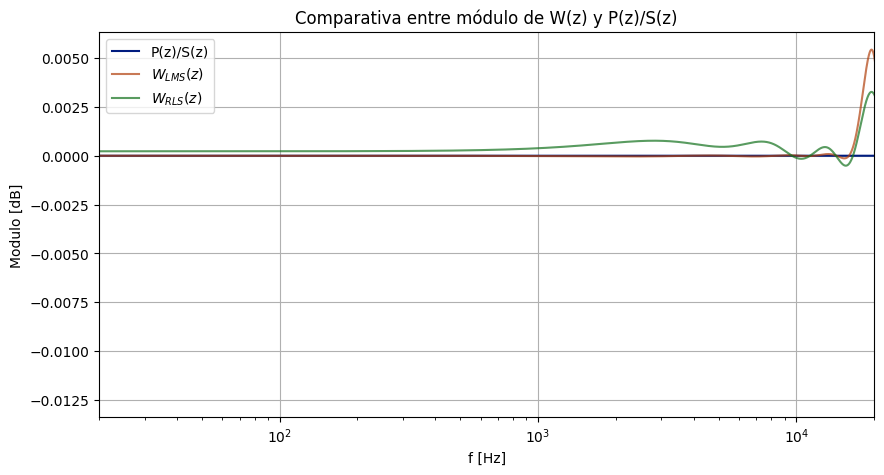

In [62]:
hp.plot_compare(results_lms, results_rls, P, S, x, sound)

Mismo sistema que antes pero con ruido de calle

In [73]:
x = lambda n: Street[0][:n] if isinstance(n, (int, float)) else Street[0][n]

sound = lambda n: 0

w_order = 10
wi = np.zeros(w_order)
mu = 0.1
P = ([0.25710141,  0.56759341,  0.36275683, -0.14074494, -0.16174654,  \
        0.12823306,  0.05811698, -0.11620306,  0.01515356,  0.08046367, \
       -0.05774555, -0.02982777,  0.06513562, -0.0166772 , -0.04321455, \
        0.04235021,  0.00806632, -0.0412385 ,  0.02130754,  0.02045124, \
       -0.03241952,  0.00518836,  0.02412965, -0.02152481, -0.00541805, \
        0.02237718, -0.01142921, -0.01095489,  0.01772157, -0.00348454, \
       -0.01262484,  0.0122324 ,  0.00174199, -0.01165468,  0.00714404, \
        0.0045253 , -0.00938547,  0.00326163,  0.00533944, -0.00672168, \
        0.00069973,  0.00497453, -0.00439681, -0.00061501,  0.00400033, \
       -0.00263338, -0.00110586,  0.00297181, -0.00153013, -0.00108514], [1] )


S = ([ 0.25710141,  0.56759341,  0.36275683, -0.14074494, -0.16174654,  \
        0.12823306,  0.05811698, -0.11620306,  0.01515356,  0.08046367, \
       -0.05774555, -0.02982777,  0.06513562, -0.0166772 , -0.04321455, \
        0.04235021,  0.00806632, -0.0412385 ,  0.02130754,  0.02045124, \
       -0.03241952,  0.00518836,  0.02412965, -0.02152481, -0.00541805, \
        0.02237718, -0.01142921, -0.01095489,  0.01772157, -0.00348454, \
       -0.01262484,  0.0122324 ,  0.00174199, -0.01165468,  0.00714404, \
        0.0045253 , -0.00938547,  0.00326163,  0.00533944, -0.00672168, \
        0.00069973,  0.00497453, -0.00439681, -0.00061501,  0.00400033, \
       -0.00263338, -0.00110586,  0.00297181, -0.00153013, -0.00108514], [1] )

S_hat = S

N = 100000
x_test = x(N)
xf = sp.lfilter(S[0], S[1], x(N))

lamdaRLS = np.exp(-1/fs*30e-3) # 0.999306
deltaRLS = np.var(xf) * (1-lamdaRLS)
print("Delta RLS: ", deltaRLS)


results_lms = hp.fxnlms_sim(wi, mu, P, S, S_hat, x, sound, w_order, N = fs*8)
results_rls = hp.fxrls_sim(lamdaRLS, deltaRLS, P, S, S_hat, x, sound, w_order, w_order + 50, N = fs*8)


Delta RLS:  8.827251201789865e-10


IntProgress(value=0, max=384000)

6.423059110378155e-24

IntProgress(value=0, max=384000)

'Señal error LMS:'

'Señal error RLS:'

'Señal interferencia:'

'Señal interferencia + sonido:'

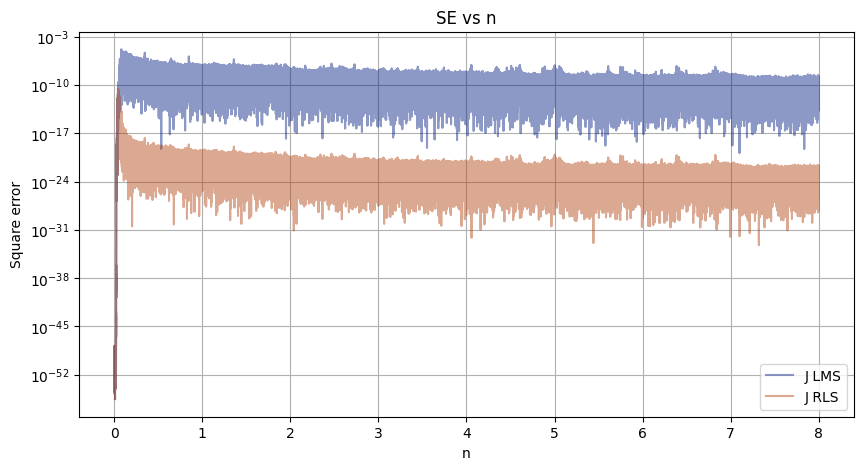

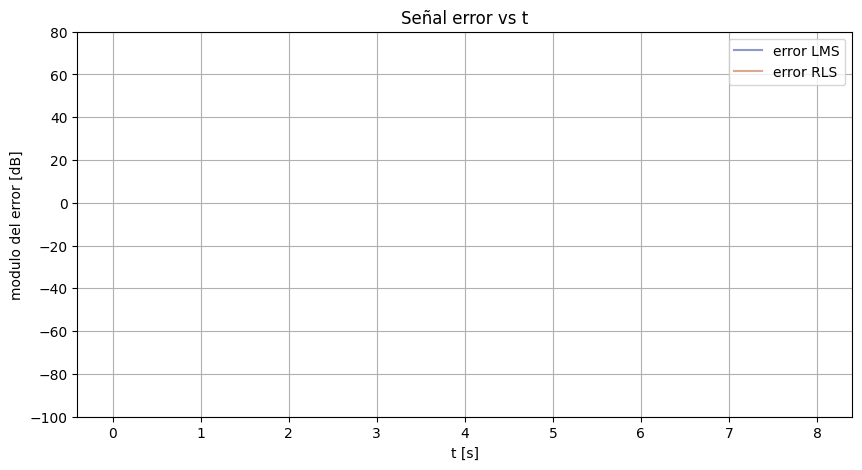

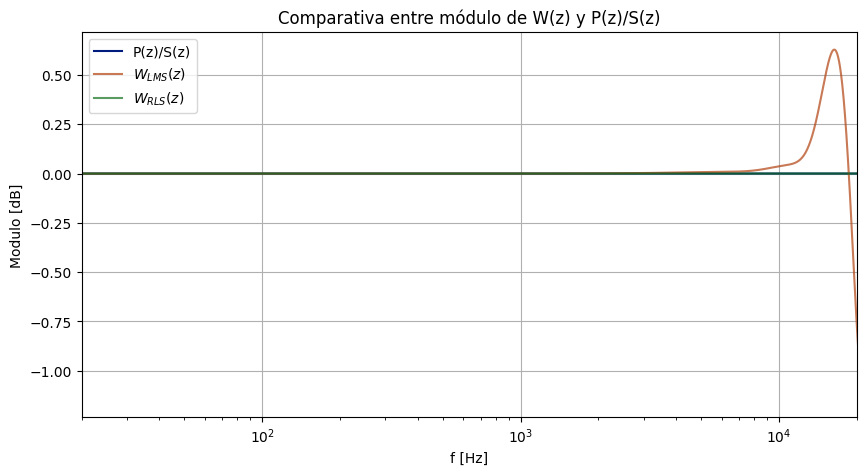

In [75]:
hp.plot_compare(results_lms, results_rls, P, S, x, sound)

In [31]:
x = lambda n: np.random.normal(0, 0.1, size=n if isinstance(n, int) else len(n))

sound = lambda n: Voice[n]

w_order = 1000
wi = np.zeros(w_order)
mu = 0.001
P = [acousticPaths[4], [1]]

S = [acousticPaths[0], [1]]

x_vals = np.random.normal(0, 1, size=10000)
y = sp.lfilter(S[0], S[1], x_vals)
wo, _, _ = hp.get_optimal_params(x_vals, y, 500)

S_hat = [wo, [1]]

N = 100000
x_test = x(N)
xf = sp.lfilter(S[0], S[1], x(N))

lamdaRLS = np.exp(-1/fs*30e-3) # 0.999306
deltaRLS = np.var(xf) * (1-lamdaRLS)
deltaRLS = 1
print("Delta RLS: ", deltaRLS)

results_lms = hp.fxnlms_sim(wi, mu, P, S, S_hat, x, sound, w_order, N = fs*8)
results_rls = hp.fxrls_sim(lamdaRLS, deltaRLS, P, S, S_hat, x, sound, w_order, w_order + 100, N = fs*1)

Delta RLS:  1


IntProgress(value=0, max=48000)

2.146464491766963e-05

KeyboardInterrupt: 

In [ ]:
hp.plot_compare(results_lms, results_rls, P, S, x, sound)

In [ ]:
x = lambda n: np.random.normal(0, 0.3, size=n if isinstance(n, int) else len(n))

sound = lambda n: Voice[n]

w_order = 200
wi = np.zeros(w_order)
mu = 0.005
P = [Proom, [1]]

S = [Sroom, [1]]

x_vals = np.random.normal(0, 1, size=10000)
y = sp.lfilter(S[0], S[1], x_vals)
wo, _, _ = hp.get_optimal_params(x_vals, y, 1000)

S_hat = [wo, [1]]


N = 100000
x_test = x(N)
xf = sp.lfilter(S[0], S[1], x(N))
N = len(xf)
R = sp.correlate(xf, xf)/N
R = R[N-w_order: N][::-1]
matR = linalg.toeplitz(R)
lambdas, _= linalg.eig(matR)

sigmaS = np.sum(np.array(S[0])**2)
k = np.arange(len(S[0]))
tauS = np.sum(k*np.array(S[0])**2)
deltaEq = tauS/sigmaS

lamdaRLS =np.exp(-1/fs*30e-3) # 0.999306
deltaRLS = np.var(xf) * (1-lamdaRLS)
print("Delta RLS: ", deltaRLS)
mu = 0.1/(np.var(xf)*(w_order + 2*deltaEq))

results_lms = hp.fxnlms_sim(wi, mu, P, S, S_hat, x, sound, w_order, N = fs*8)
results_rls = hp.fxrls_sim(lamdaRLS, deltaRLS, P, S, S_hat, x, sound, w_order, w_order + 50, N = fs*8)

In [ ]:
hp.plot_compare(results_lms, results_rls, P, S, x, sound)

Aca es una situacion mas real, el ruido de interferencia es de la calle, y lo que quiero reproducir es mi voz. Funciona bastante bien

In [40]:
x = lambda n: Street[0][:n] if isinstance(n, (int, float)) else Street[0][n]

sound = lambda n: Voice[n]*0.3

w_order = 100
wi = np.zeros(w_order)
mu = 0.01
P = [Proom, [1]]

S = [Sroom, [1]]

x_vals = np.random.normal(0, 1, size=10000)
y = sp.lfilter(S[0], S[1], x_vals)
wo, _, _ = hp.get_optimal_params(x_vals, y, 1000)

S_hat = [wo, [1]]

xf = sp.lfilter(S[0], S[1], Street[0])

print(np.var(xf))
lamdaRLS =np.exp(-1/fs*15e-3) # 0.999306
deltaRLS = np.var(xf) * (1-lamdaRLS)**(-0.5)

print("Delta RLS: ", deltaRLS)


results_lms = hp.fxnlms_sim(wi, mu, P, S, S_hat, x, sound, w_order, N = fs*8)
results_rls = hp.fxrls_sim(lamdaRLS, deltaRLS, P, S, S_hat, x, sound, w_order, w_order + 50, N = fs*8)

9.667977255418295
Delta RLS:  17294.604830498283


IntProgress(value=0, max=384000)

0.12437910328555134

KeyboardInterrupt: 

In [ ]:
hp.plot_compare(results_lms, results_rls, P, S, x, sound)

Igual q antes pero con musica

In [44]:
x = lambda n: Street[0][:n] if isinstance(n, (int, float)) else Street[0][n]

sound = lambda n: Song[0][n]*0.1

w_order = 100
wi = np.zeros(w_order)
mu = 0.01
P = [Proom, [1]]

S = [Sroom, [1]]

x_vals = np.random.normal(0, 1, size=10000)
y = sp.lfilter(S[0], S[1], x_vals)
wo, _, _ = hp.get_optimal_params(x_vals, y, 300)

S_hat = [wo, [1]]

N = 100000
x_test = x(N)
xf = sp.lfilter(S[0], S[1], x(N))

lamdaRLS =np.exp(-1/fs*30e-3) # 0.999306
deltaRLS = np.var(xf) * (1-lamdaRLS)**(-0.3)

print("Delta RLS: ", deltaRLS)


results_lms = hp.fxnlms_sim(wi, mu, P, S, S_hat, x, sound, w_order, N = fs*8)
results_rls = hp.fxrls_sim(lamdaRLS, deltaRLS, P, S, S_hat, x, sound, w_order, w_order + 50, N = fs*8)

Delta RLS:  354.4776220501481


IntProgress(value=0, max=384000)

0.028709479638981964

KeyboardInterrupt: 

In [ ]:
hp.plot_compare(results_lms, results_rls, P, S, x, sound)